In [149]:
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import tifffile
from IPython.display import display
import PIL.Image
%matplotlib inline

In [155]:
def show_fig(ar_fig):
    display(PIL.Image.fromarray(ar_fig))
    return
    kwargs_fig = dict(
        dpi = 300,
    )
    kwargs_subplots = dict(
        xticks = [],
        yticks = [],
    )    
    fig, ax = plt.subplots(subplot_kw=kwargs_subplots, **kwargs_fig)
    ax.imshow(ar_fig, cmap='gray')
    plt.show()
    plt.close(fig)

def to_uint8(ar, val_min, val_max):
    ar_new = ar.copy()
    if val_min is not None: ar_new[ar_new < val_min] = val_min
    if val_max is not None: ar_new[ar_new > val_max] = val_max
    ar_new -= np.min(ar_new)
    ar_new = ar_new/np.max(ar_new)*256.0
    ar_new[ar_new >= 256.0] = 255.0
    return ar_new.astype(np.uint8)

z_slices: [8, 16, 24]
img_00_DNA.tif
float32 334.0 875.0
img_00_bright-field.tif
float32 -11.2798 10.3626
img_00_prediction.tif
float32 375.994 678.825


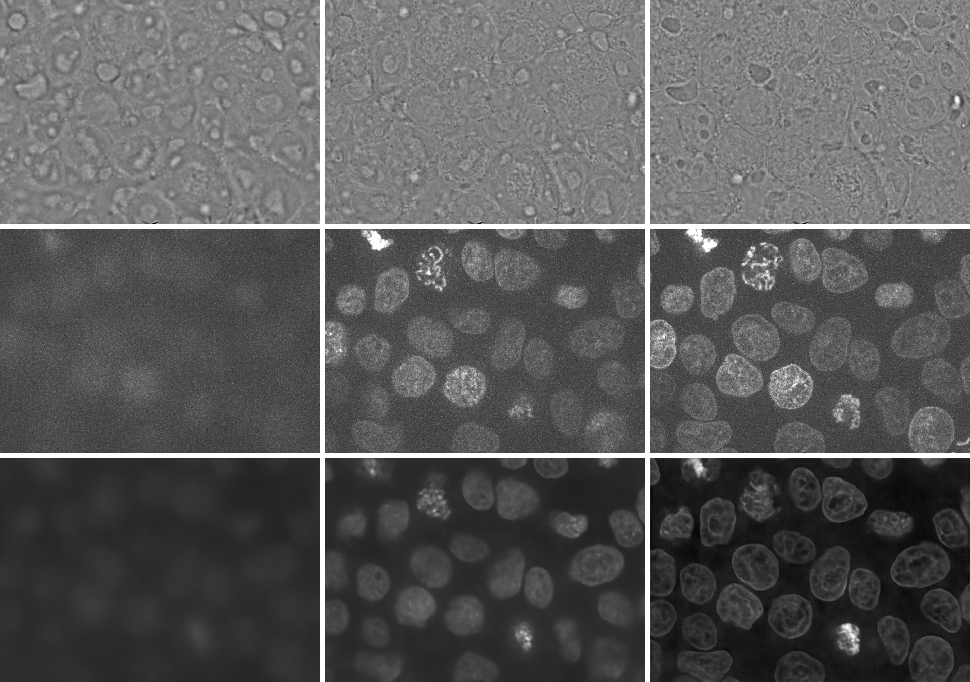

img_01_DNA.tif
float32 338.0 723.0
img_01_bright-field.tif
float32 -5.00349 5.64378
img_01_prediction.tif
float32 380.608 514.666


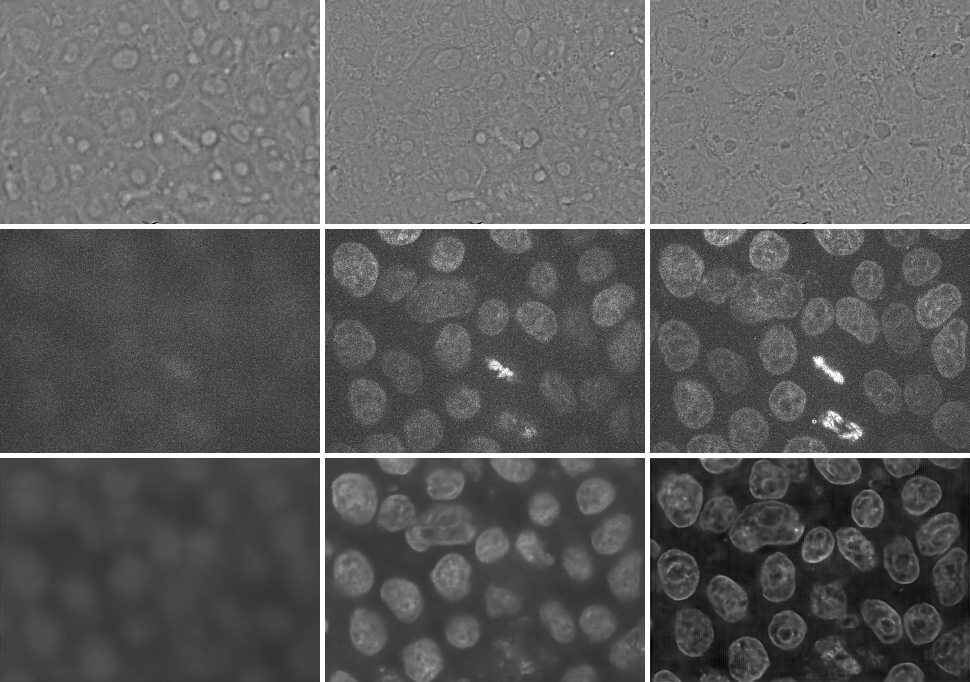

img_02_DNA.tif
float32 347.0 657.0
img_02_bright-field.tif
float32 -12.0642 10.1795
img_02_prediction.tif
float32 392.546 572.09


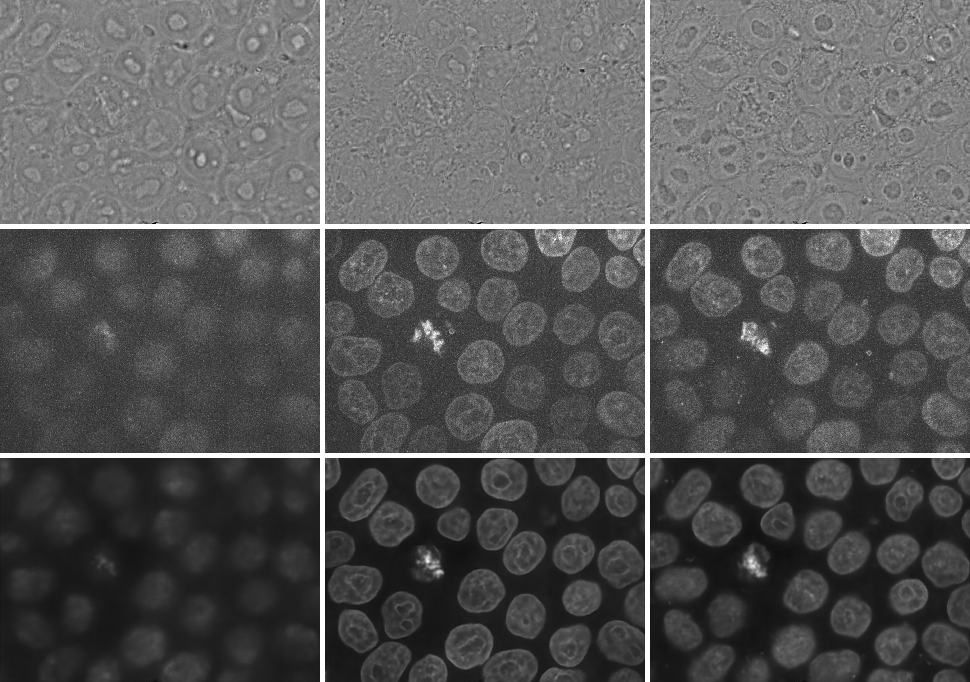

In [162]:
path_source = '../test_output/no_hots_norm_v5_50k_cropped'
#tag_signal = 'signal'
#tag_target = 'target'
tag_signal = 'bright'
tag_target = 'DNA'
tag_prediction = 'prediction'

paths_tifs = sorted([i.path for i in os.scandir(path_source) if i.is_file() and i.path.lower().endswith('.tif')])
pattern = re.compile(r'_(\d+)_')

padding_h = 5
padding_v = 5
n_z_per_img = 3

val_range_signal = (-10, 10)
#val_range_target = (-3, 8)
#val_range_prediction = (0, 5)
val_range_target = (None, 600)
val_range_prediction = (None, 600)

z_indices = [int((i + 1)*(ar.shape[0]/(n_z_per_img + 1))) for i in range(n_z_per_img)]
print('z_slices:', z_indices)

idx_old = None
for i, path in enumerate(paths_tifs):
    idx_row = None
    path_basename = os.path.basename(path)
    print(path_basename)
    match = pattern.search(path_basename)
    idx_img = match.groups()[0]
    if tag_signal in path_basename:
        idx_row = 0
        val_min, val_max = val_range_signal
    if tag_target in path_basename:
        idx_row = 1
        val_min, val_max = val_range_target
    if tag_prediction in path_basename:
        idx_row = 2
        val_min, val_max = val_range_prediction
    if idx_row is not None:
        tmp = tifffile.imread(path)
        print(tmp.dtype, np.min(tmp), np.max(tmp))
        ar = to_uint8(tifffile.imread(path), val_min, val_max)
        if idx_img != idx_old:
            n_rows_done = 0
            idx_old = idx_img
            shape = (ar.shape[1]*3 + 2*padding_v, ar.shape[2]*n_z_per_img + (n_z_per_img - 1)*padding_h)
            ar_fig = np.ones(shape, dtype=np.uint8)*255
        offset_y = idx_row*(ar.shape[1] + padding_v)
        for idx_col, z_index in enumerate(z_indices):
            offset_x = idx_col*(ar.shape[2] + padding_h)
            ar_fig[offset_y:offset_y + ar.shape[1], offset_x:offset_x + ar.shape[2]] = ar[z_index, ]
        n_rows_done += 1
        if n_rows_done == 3:
            show_fig(ar_fig)
    if i >= 10:
        break